<a href="https://colab.research.google.com/github/kmogis/project/blob/master/TmIG_v210701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting Mumax3

First we need to load the following modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# FigForm is just for decoration of figures               
def FigForm(fsize):
#     plt.rcParams['text.usetex'] = True
    plt.rcParams['figure.figsize']=[8.*(1+np.sqrt(5.))/2.,8.]
    plt.rcParams['font.size'] = fsize
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['xtick.major.size']=10
    plt.rcParams['ytick.major.size']=10
    plt.rcParams['xtick.minor.size']=5
    plt.rcParams['ytick.minor.size']=5
    plt.rcParams['xtick.direction']='in'
    plt.rcParams['ytick.direction']='in'
    plt.rcParams['grid.color']='lightgrey'
    plt.rcParams['grid.linestyle']='--'
    plt.rcParams['grid.linewidth']=1.
    plt.rcParams['axes.axisbelow'] ='line'
    plt.rcParams['axes.grid'] = False
    return
    
FigForm(15)

Need to download mumax using the code below.

In [2]:
try:
    import google.colab
except ImportError:
    pass
else:
    !wget https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
    !tar -xvf mumax3.10_linux_cuda10.1.tar.gz
    !rm mumax3.10_linux_cuda10.1.tar.gz
    !rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10
    import os
    os.environ['PATH'] += ":/content/mumax3.10"

--2021-07-01 04:32:04--  https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
Resolving mumax.ugent.be (mumax.ugent.be)... 157.193.40.77
Connecting to mumax.ugent.be (mumax.ugent.be)|157.193.40.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150707207 (144M) [application/x-gzip]
Saving to: ‘mumax3.10_linux_cuda10.1.tar.gz’

mumax3.10_linux_cud 100%[===================>] 143.73M  32.7MB/s    in 5.1s    

2021-07-01 04:32:10 (28.4 MB/s) - ‘mumax3.10_linux_cuda10.1.tar.gz’ saved [150707207/150707207]

mumax3.10_linux_cuda10.1/
mumax3.10_linux_cuda10.1/mumax3-server
mumax3.10_linux_cuda10.1/lib/
mumax3.10_linux_cuda10.1/lib/libcurand.so.10
mumax3.10_linux_cuda10.1/lib/libcufft.so.10
mumax3.10_linux_cuda10.1/mumax3
mumax3.10_linux_cuda10.1/LICENSE
mumax3.10_linux_cuda10.1/mumax3-convert


Let's make some function to run mumax3

In [34]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]

    
    return table

def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields
    
def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files
    
    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)
    
    # call mumax3 to execute this script
    p = run(["mumax3","-f",scriptfile], stdout=PIPE, stderr=STDOUT)
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))
        
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
        
    fields = read_mumax3_ovffiles(outputdir)
    
    return table, fields

## Dispersion in 50 nm thick YIG @ 200 mT

Then we start with 50 nm thick YIG film. The field of 200 mT is applied in plane. In particualr, we are interested in backward volume modes.

In [6]:
# NUMERICAL PARAMETERS
fmax = 20e9        # maximum frequency (in Hz) of the sinc pulse
T    = 10e-8        # simulation time (longer -> better frequency resolution)
dt   = 1/(2*fmax)  # the sample time
dx   = 5e-9        # cellsize
dy   = 5e-9        # cellsize
dz   = 50e-9        # cellsize
nx   = 1024       # number of cells
ny   = 1       # number of cells
nz   = 1      # number of cells

# MATERIAL/SYSTEM PARAMETERS
Bx    = 0.2        # Bias field along the z direction
By    = 0.0
A     = 3.7e-12     # exchange constant
Ms    = 139260      # saturation magnetization in A/m
alpha = 0.0001       # damping parameter
gamma = 1.79e11    # gyromagnetic ratio

#enabledemag = false
# Ku1 = 800e3
# AnisU = vector(0,0,-1)
#defregion(1,rect(10*{dx},inf))
#B_ext.setregion(1, vector( {Bx}+0 * sinc(2*pi*{fmax}*(t-{T}/2)), {By},0 )    )
set
script=f"""
setgridsize({nx},{ny},{nz})
setcellsize({dx},{dy},{dz})

Aex = {A}
Msat = {Ms}
alpha = {alpha}
enabledemag = true
SetPBC(0,1024,0)
B_ext = vector({Bx},{By},0)
defregion(1,rect(1*{dx},inf,))
B_ext.setregion(1, vector( {Bx}+0, {By}, 10* sinc(2*pi*{fmax}*(t-{T}/2) )))

m = uniform(1,0,0.01).add(0.1,randommag())
autosave(m,{dt})
run({T})
"""
 
table, fields = run_mumax3(script,"spinwaves")

Now with the calculation results, we fourier transform and obtain the following curve, which shows the intensity of dynamic magnetization in wave vector vs frequency plot.

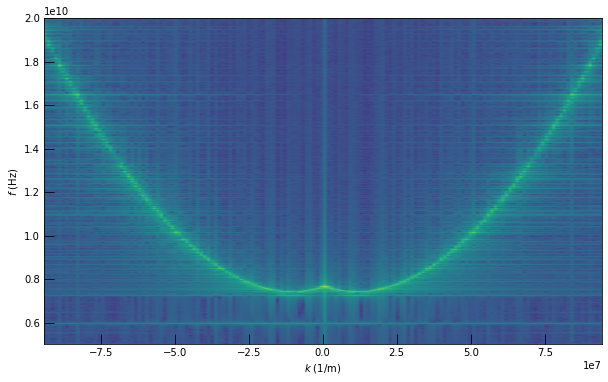

In [7]:
# Stack all snapshots of the magnetization on top of each other
m = np.stack([fields[key] for key in sorted(fields.keys())])

# Select the x component
mx = m[:,0,0,0,:]
mx = m[:,2,0,0,:]

# Apply the two dimensional FFT
mx_fft = np.fft.fft2(mx)
mx_fft = np.fft.fftshift(mx_fft)

plt.figure(figsize=(10,6))

# Show the intensity plot of the 2D FFT
extent = [ -(2*np.pi)/(2*dx), (2*np.pi)/(2*dx), -1/(2*dt), 1/(2*dt)] # extent of k values and frequencies
plt.imshow(np.abs(mx_fft)**0.1, extent=extent, aspect='auto', origin='lower')

# plt.xlim([-7e7,7e7])
# plt.ylim([0,fmax])
plt.ylabel("$f$ (Hz)")
plt.xlabel("$k$ (1/m)")
plt.ylim(5e9,fmax)
plt.xlim(-(0.3*np.pi)/(2*dx), (0.3*np.pi)/(2*dx))
plt.show()


## Analytic calculation

We can obtain a very similar curve the following analytic calculation

In [32]:
# Note that magnetic field is always along the x axis.
# You can change the direction of snp.pin wave by changing kx and ky: kx=0 yields DE
# By putting theta = 90 will results in inplane magnetization
# When theta deviates from, magnetization starts to have out of plane components.

def P(kx,ky,n,L):
    if n==0:
        return 1 - ( 1 - np.e**( -np.sqrt(kx**2+ky**2)*L ) ) / ( np.sqrt(kx**2+ky**2)*L ) 
    else:
        return (kx**2+ky**2)/(kx**2+ky**2+(n*np.pi/L)**2) -\
    2*(kx**2+ky**2)**2*( 1-(-1)**n*np.e**( -np.sqrt(kx**2+ky**2)*L ) )\
    /( (kx**2+ky**2+(n*np.pi/L)**2)**2 * np.sqrt(kx**2+ky**2)*L )
    
def F(kx,ky,n,muM,muH,D,L,theta):
    cosphi2=kx**2/(kx**2+ky**2)
    sinphi2=ky**2/(kx**2+ky**2)
    sintheta2=(np.sin(theta))**2
    costheta2=(np.cos(theta))**2
    
    return sintheta2+P(kx,ky,n,L)*costheta2-P(kx,ky,n,L)*cosphi2*sintheta2\
+sintheta2*P(kx,ky,n,L)*(1-P(kx,ky,n,L))*muM /(muH+D*(kx**2+ky**2+(n*np.pi/L)**2))*sinphi2

def KS_Freq(g,kx,ky,n,muM,muH,D,L,theta):
    return g*np.sqrt( (muH+D*(kx**2+ky**2+(n*np.pi/L)**2))*\
                  (muH+D*(kx**2+ky**2+(n*np.pi/L)**2) + muM*F(kx,ky,n,muM,muH,D,L,theta) ) )

def KS_Freq_Aniso(g,kx,ky,n,muM,muH,D,L,theta,Ku):
    return g*np.sqrt( (muH+D*(kx**2+ky**2+(n*np.pi/L)**2))*\
                  (muH+D*(kx**2+ky**2+(n*np.pi/L)**2) + muM*F(kx,ky,n,muM,muH,D,L,theta)\
                   -2*Ku/muM*mu0                  ) )

A very nice agreement can be seen as below

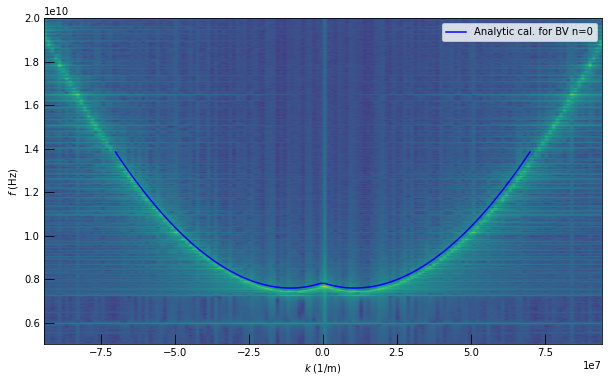

In [10]:
# Stack all snapshots of the magnetization on top of each other
m = np.stack([fields[key] for key in sorted(fields.keys())])

# Select the x component
mx = m[:,0,0,0,:]
mx = m[:,2,0,0,:]

# Apply the two dimensional FFT
mx_fft = np.fft.fft2(mx)
mx_fft = np.fft.fftshift(mx_fft)

plt.figure(figsize=(10,6))

# Show the intensity plot of the 2D FFT
extent = [ -(2*np.pi)/(2*dx), (2*np.pi)/(2*dx), -1/(2*dt), 1/(2*dt)] # extent of k values and frequencies
plt.imshow(np.abs(mx_fft)**0.1, extent=extent, aspect='auto', origin='lower')



# Parameters
mu0 = 4*np.pi*10**-7;#H/m
gYIG = 28.6;# gamma over 2pi: in unit of GHz/T from 10.1109/LMAG.2014.2350958 
muMYIG = 0.175; #Wettling,M.G.Cottam,and J.R.Sandercock,J.Phys.C:Solid State Phys.8,211 (1975) *)
AYIG = 0.37*10**-11;
dexYIG = 2*AYIG/(muMYIG/mu0)#T m^2 
thickYIG = 50*10**-9 #meter;
muH=200 # mT

# Plot analytic solution
X=np.linspace(-70e6,70e6,100)
plt.plot(X,1e9*KS_Freq(gYIG,X,0,0,muMYIG,muH/1000,dexYIG,thickYIG,90*np.pi/180),"b",\
         label='Analytic cal. for BV n=0')
plt.ylim(5e9,fmax)
plt.xlim(-(0.3*np.pi)/(2*dx), (0.3*np.pi)/(2*dx))

plt.ylabel("$f$ (Hz)")
plt.xlabel("$k$ (1/m)")
plt.legend()

## Dispersion with PMA : 50 nm thick TmIG @ 200 mT applied in plane

When including the anisotropy as in the case of TmIG, we simply include the Ku1, which is the uniaxial anisotropy. Here we choose a value that compensates the demagnezation field completely. This can be viewed as a system with no effective anisotropy, where the magnetization does not have any preferential direction.

In [12]:
# NUMERICAL PARAMETERS
fmax = 20e9        # maximum frequency (in Hz) of the sinc pulse
T    = 10e-8        # simulation time (longer -> better frequency resolution)
dt   = 1/(2*fmax)  # the sample time
dx   = 5e-9        # cellsize
dy   = 5e-9        # cellsize
dz   = 50e-9        # cellsize
nx   = 1024       # number of cells
ny   = 1       # number of cells
nz   = 1      # number of cells

# MATERIAL/SYSTEM PARAMETERS
Bx    = 0.2        # Bias field along the z direction
By    = 0.0
A     = 3.7e-12     # exchange constant
Ms    = 139260      # saturation magnetization in A/m
alpha = 0.0001       # damping parameter
gamma = 1.79e11    # gyromagnetic ratio
Ku1 = 12185 # anisotropy field in A/m

script=f"""
setgridsize({nx},{ny},{nz})
setcellsize({dx},{dy},{dz})

Aex = {A}
Msat = {Ms}
alpha = {alpha}
Ku1 = {Ku1}
AnisU = vector(0,0,1)

enabledemag = true

SetPBC(0,1024,0)
B_ext = vector({Bx},{By},0)
defregion(1,rect(1*{dx},inf,))
B_ext.setregion(1, vector( {Bx}+0, {By}, 10* sinc(2*pi*{fmax}*(t-{T}/2) )))

m = uniform(1,0,0.01).add(0.1,randommag())
autosave(m,{dt})
run({T})
"""
 
table, fields = run_mumax3(script,"spinwaves")

Incorporating the anisotropy field is done modifying the KS_Freq function slightly (now KS_Freq_Aniso function takes care of the anisotropy field). A nice agreement can be seen between red line and the simulation.

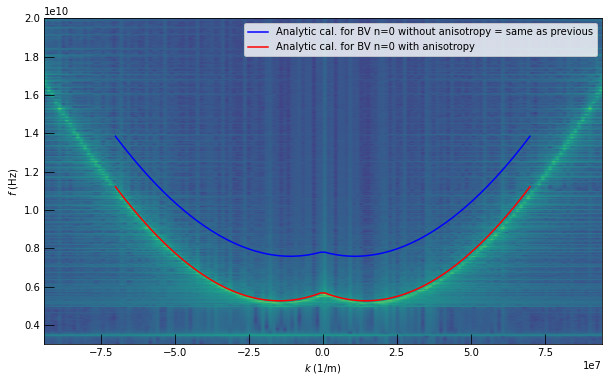

In [33]:
# Stack all snapshots of the magnetization on top of each other
m = np.stack([fields[key] for key in sorted(fields.keys())])

# Select the x component
mx = m[:,0,0,0,:]
mx = m[:,2,0,0,:]

# Apply the two dimensional FFT
mx_fft = np.fft.fft2(mx)
mx_fft = np.fft.fftshift(mx_fft)

plt.figure(figsize=(10,6))

# Show the intensity plot of the 2D FFT
extent = [ -(2*np.pi)/(2*dx), (2*np.pi)/(2*dx), -1/(2*dt), 1/(2*dt)] # extent of k values and frequencies
plt.imshow(np.abs(mx_fft)**0.1, extent=extent, aspect='auto', origin='lower')

# Parameters
mu0 = 4*np.pi*10**-7;#H/m
gYIG = 28.6;# gamma over 2pi: in unit of GHz/T from 10.1109/LMAG.2014.2350958 
muMYIG = 0.175; #Wettling,M.G.Cottam,and J.R.Sandercock,J.Phys.C:Solid State Phys.8,211 (1975) *)
AYIG = 0.37*10**-11;
dexYIG = 2*AYIG/(muMYIG/mu0)#T m^2 
thickYIG = 50*10**-9 #meter;
muH=200 # mT

# Plot analytic solution
X=np.linspace(-70e6,70e6,100)
plt.plot(X,1e9*KS_Freq(gYIG,X,0,0,muMYIG,muH/1000,dexYIG,thickYIG,90*np.pi/180),"b",\
         label='Analytic cal. for BV n=0 without anisotropy = same as previous')
plt.plot(X,1e9*KS_Freq_Aniso(gYIG,X,0,0,muMYIG,muH/1000,dexYIG,thickYIG,90*np.pi/180,12185),"r",\
         label='Analytic cal. for BV n=0 with anisotropy')
plt.ylim(3e9,fmax)
plt.xlim(-(0.3*np.pi)/(2*dx), (0.3*np.pi)/(2*dx))

plt.ylabel("$f$ (Hz)")
plt.xlabel("$k$ (1/m)")
plt.legend()